In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import re
import sys
from imp import reload
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
def df_preview(df):
  print(df.shape)
  return df

def df_count(df, cols, sort=False):
  counts = df.groupby(cols).size().rename("n").reset_index()
  
  if sort:
      return counts.sort_values("n", ascending=False)
  else:
      return counts.sort_values(cols)

def print_x_y(X, y, suffix=None):
  suffix = "" if not suffix else "_" + suffix
  print(f"y{suffix}:", y.shape, "~", f"X{suffix}:", X.shape)

def pretty_plot(ax, title, xlab, ylab, sizes=(18, 14, 13)):
  ax.set_title(title, fontsize=sizes[0], y=1.01)
  ax.set_xlabel(xlab, fontsize=sizes[1])
  ax.set_ylabel(ylab, fontsize=sizes[1])

  ax.tick_params(axis="x", labelsize=sizes[2])
  ax.tick_params(axis="x", labelsize=sizes[2])

## Peaceful Countries & Non Peaceful Countries

In [6]:
from typing import List

peaceful_countries = ['GB', 'AU', 'CA', 'SG', 'NZ', 'IE']
non_peaceful_countries = ['PK', 'BD', 'NG', 'KE', 'ZA', 'TZ']

def get_society_label(country: str, peaceful: List[str], nonpeaceful: List[str]) -> str:
  if country in peaceful:
    return "peaceful"
  elif country in nonpeaceful:
    return "nonpeaceful"
  else:
    return "other"

def country_is_peaceful(society):
  return society.lower() == "peaceful"

## Import data to Datafrmae

In [7]:
BASE_DIR = "/content/drive/MyDrive/peace-speech-project/"

data_file_path = os.path.join(BASE_DIR, "data", "domestic_articles__ngram__stopwords__lemmatized.csv")
articles = pd.read_csv(data_file_path, index_col=[0])
articles = articles.dropna().reset_index()

articles["society"] = articles.country.apply(
    get_society_label, 
    peaceful=peaceful_countries, 
    nonpeaceful=non_peaceful_countries
)

articles["is_peaceful"] = articles.society.apply(country_is_peaceful)

print(articles.shape)
articles

(723590, 8)


,index,article_id,country,publisher,year,article_text,society,is_peaceful
0,0,71409778,AU,perthnow.com.au,2019,Labor continue pursuit Angus Taylor Federal La...,peaceful,True
1,1,71101824,AU,perthnow.com.au,2019,For many year South Australia unenviable reput...,peaceful,True
2,2,71512141,AU,perthnow.com.au,2019,Jamie Maclaren open join Melbourne City tough ...,peaceful,True
3,3,71147035,AU,perthnow.com.au,2019,Perth man hang arm drug gang Rio favela Topics...,peaceful,True
4,4,71206307,AU,perthnow.com.au,2019,MP allegedly told fake donor lie ICAC Dominica...,peaceful,True
...,...,...,...,...,...,...,...,...
723585,724276,7645720,US,Variety,2016,Asian Film Awards Honor Best Region 's Filmmak...,other,False
723586,724277,15386389,US,Variety,2016,If Terrence Malick 's Voyage Time The IMAX Exp...,other,False
723587,724278,7979032,US,Variety,2016,Hayes travel production back Broadway star L.A...,other,False
723588,724279,14476469,US,Variety,2016,At Los Angeles premiere Queen Katwe screen El ...,other,False


In [8]:
articles__no_others = articles[articles.society != "other"].copy()
articles__no_others["is_peaceful"] = articles__no_others.is_peaceful.astype(int)

print(articles__no_others.shape)
articles__no_others

(417941, 8)


,index,article_id,country,publisher,year,article_text,society,is_peaceful
0,0,71409778,AU,perthnow.com.au,2019,Labor continue pursuit Angus Taylor Federal La...,peaceful,1
1,1,71101824,AU,perthnow.com.au,2019,For many year South Australia unenviable reput...,peaceful,1
2,2,71512141,AU,perthnow.com.au,2019,Jamie Maclaren open join Melbourne City tough ...,peaceful,1
3,3,71147035,AU,perthnow.com.au,2019,Perth man hang arm drug gang Rio favela Topics...,peaceful,1
4,4,71206307,AU,perthnow.com.au,2019,MP allegedly told fake donor lie ICAC Dominica...,peaceful,1
...,...,...,...,...,...,...,...,...
656179,656870,14014747,TZ,Daily News | The National Newspaper (press rel...,2016,Principal Resident Magistrate Dr Yohana Yongol...,nonpeaceful,0
656180,656871,14806484,TZ,Daily News | The National Newspaper (press rel...,2016,FULLY FLEDGED Yoga Instructors Susan Tabula fa...,nonpeaceful,0
656181,656872,9047182,TZ,Daily News | The National Newspaper (press rel...,2016,THE government divulge content report Judicial...,nonpeaceful,0
656182,656873,13915423,TZ,Daily News | The National Newspaper (press rel...,2016,Ambassador Egypt Tanzania Mr Yasser Elshawaf t...,nonpeaceful,0


In [9]:
del articles

In [10]:
mean_article_length = np.round(articles__no_others.article_text.apply(lambda x: len(x.split(" "))).mean(), 3)
mean_article_length

371.259

In [11]:
%%time

MAX_FEATURES = 6000
EMBED_SIZE = 128
RNN_CELL_SIZE = 32
MAX_LEN = int(mean_article_length)

df = articles__no_others[["article_text", "is_peaceful"]].sample(frac=1)

tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df['article_text'])
list_tokenized_train = tokenizer.texts_to_sequences(df['article_text'])
reverse_word_index = dict(map(reversed, tokenizer.word_index.items()))

X = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y = df['is_peaceful']

print_x_y(X, y)

y: (417941,) ~ X: (417941, 371)
CPU times: user 2min 47s, sys: 1.01 s, total: 2min 48s
Wall time: 2min 48s


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=116)

print_x_y(X_train, y_train, "train")
print_x_y(X_test, y_test, "test")

y_train: (334352,) ~ X_train: (334352, 371)
y_test: (83589,) ~ X_test: (83589, 371)


In [13]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [14]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def build_model(return_attention=False):
  sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
  embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

  lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

  # Getting our LSTM outputs
  (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(
      LSTM(
          RNN_CELL_SIZE, 
          return_sequences=True, 
          return_state=True
      ), name="bi_lstm_1"
  )(lstm)


  state_h = Concatenate()([forward_h, backward_h])
  state_c = Concatenate()([forward_c, backward_c])

  context_vector, attention_weights = Attention(10)(lstm, state_h)
  attention_model = keras.Model(inputs=sequence_input, outputs=attention_weights)  ## Attention Model

  dense1 = Dense(20, activation="relu")(context_vector)
  dropout = Dropout(0.05)(dense1)
  output = Dense(1, activation="sigmoid")(dropout)

  model = keras.Model(inputs=sequence_input, outputs=output)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

  if return_attention:
    return model, attention_model
  else:
    return model

model, attention_model = build_model(return_attention=True)

In [15]:
print("RNN Model")
model.summary()

RNN Model
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 371)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 371, 128)     768000      input_1[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 371, 64)      41216       embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 371, 64), (N 24832       bi_lstm_0[0][0]                  
__________________________________________________________________________________

In [16]:
print("Attention Model")
attention_model.summary()

Attention Model
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 371)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 371, 128)     768000      input_1[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 371, 64)      41216       embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 371, 64), (N 24832       bi_lstm_0[0][0]                  
______________________________________________________________________________

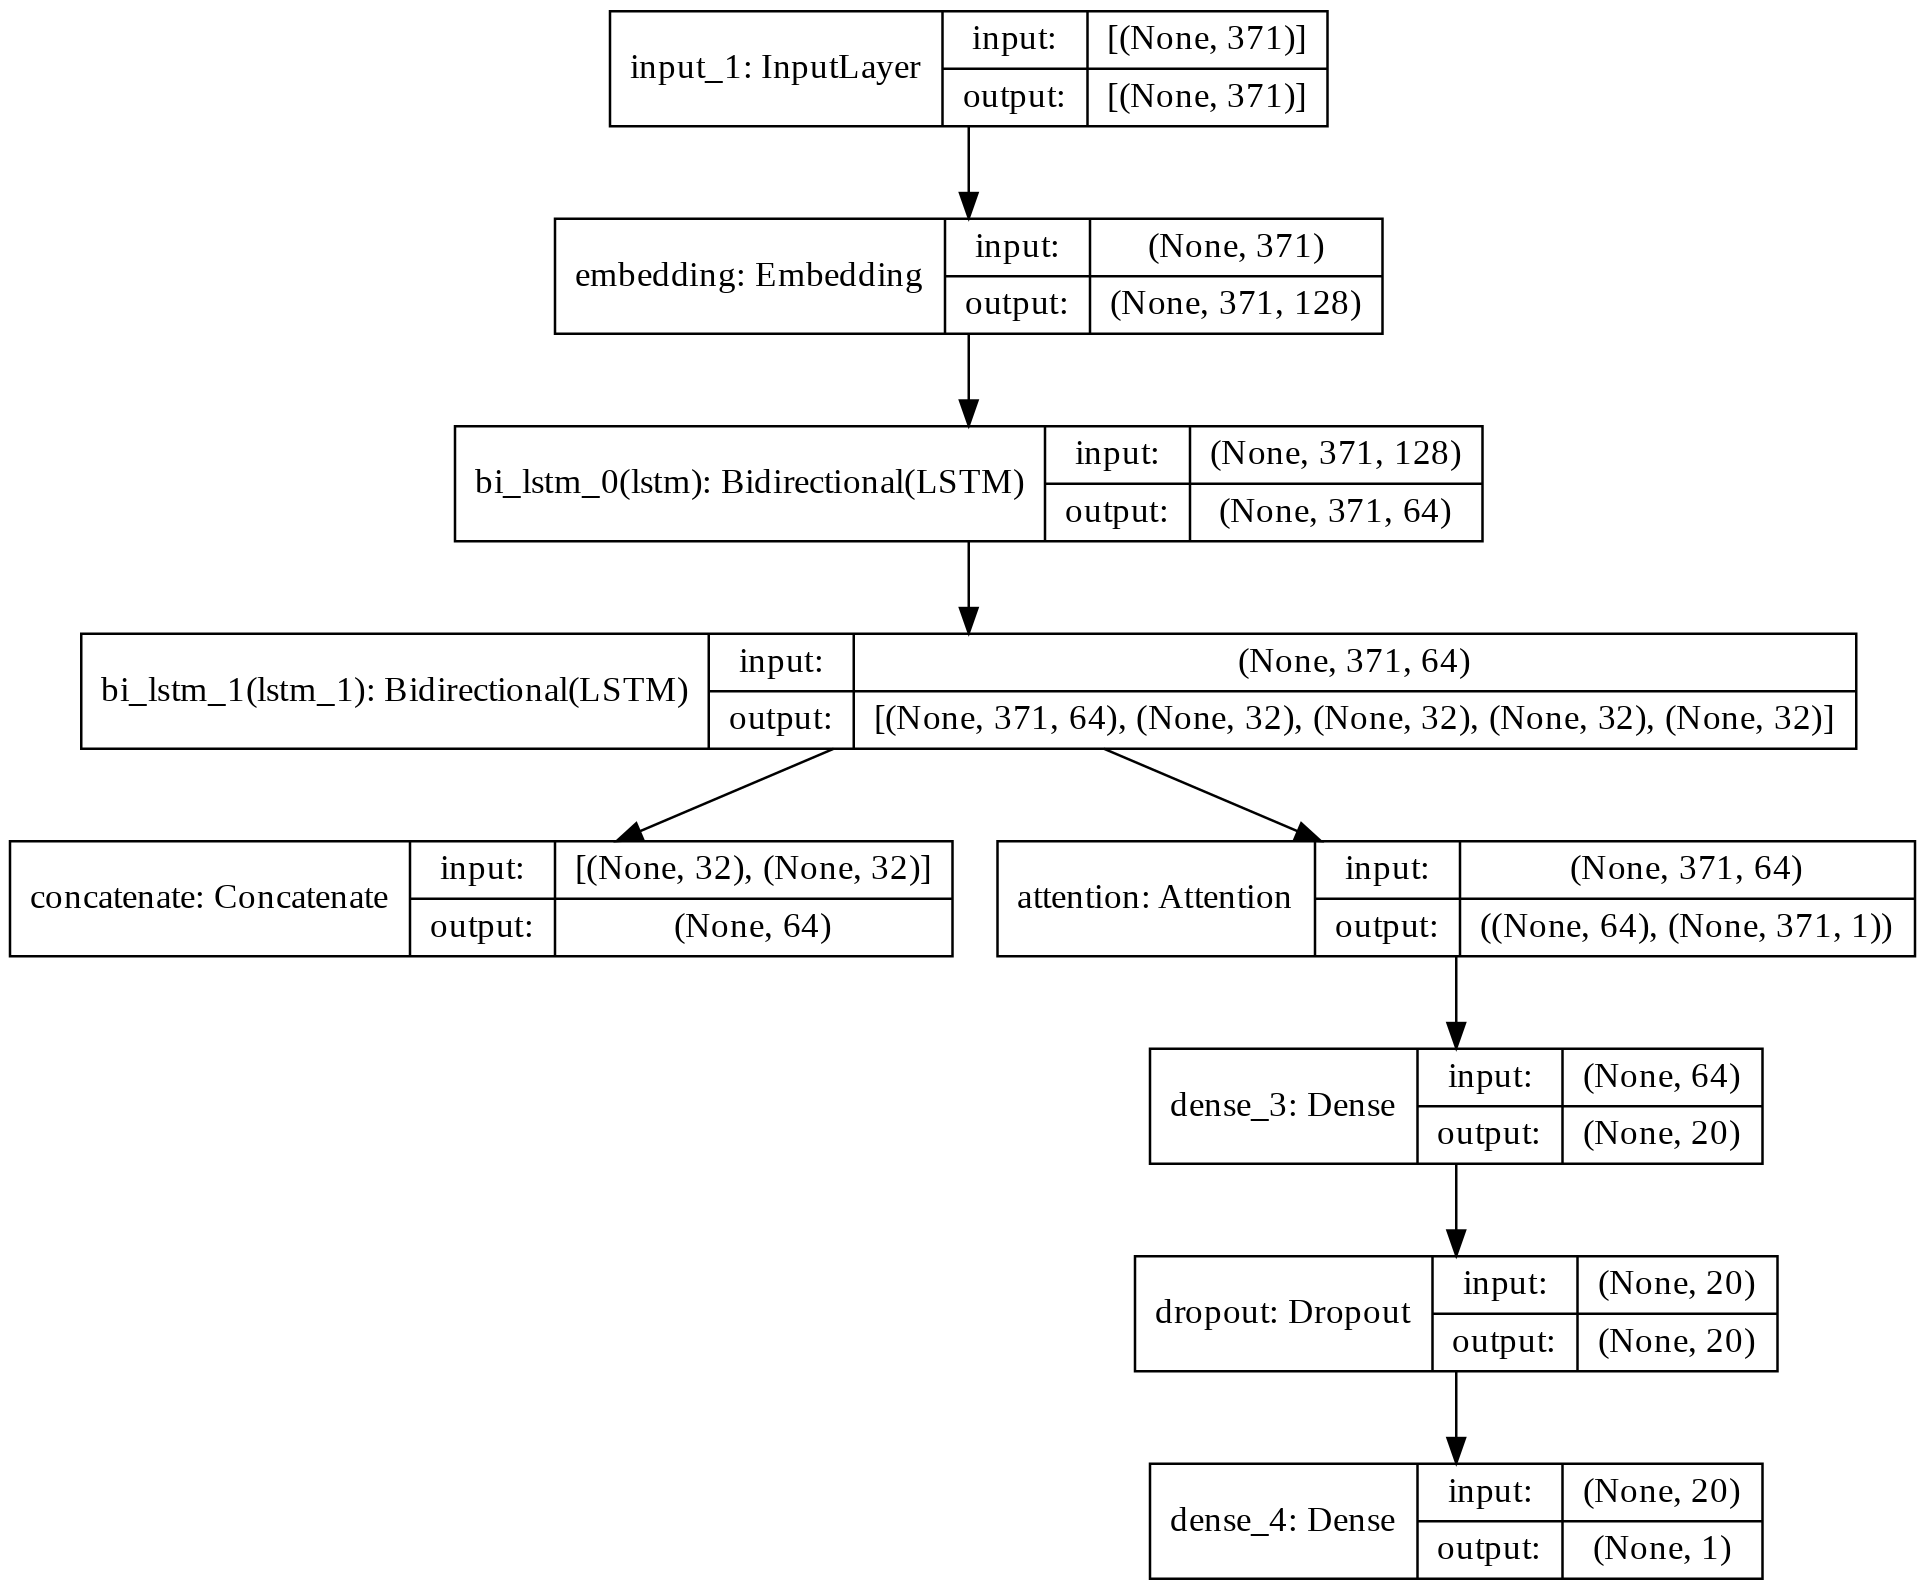

In [17]:
keras.utils.plot_model(model, show_shapes=True, dpi=180)

In [ ]:
BATCH_SIZE = 512
EPOCHS = 10

model = build_model()
history = model.fit(X_train, y_train.values, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

Epoch 1/10
523/523 [==============================] - 104s 188ms/step - loss: 0.2265 - tp: 99110.4599 - fp: 6602.5210 - tn: 27185.2939 - fn: 1499.6221 - accuracy: 0.9051 - precision: 0.9072 - recall: 0.9772 - auc: 0.9179 - val_loss: 0.0463 - val_tp: 49834.0000 - val_fp: 733.0000 - val_tn: 16040.0000 - val_fn: 264.0000 - val_accuracy: 0.9851 - val_precision: 0.9855 - val_recall: 0.9947 - val_auc: 0.9975
Epoch 2/10
523/523 [==============================] - 97s 185ms/step - loss: 0.0346 - tp: 100139.9542 - fp: 875.6718 - tn: 32805.1164 - fn: 577.1546 - accuracy: 0.9893 - precision: 0.9914 - recall: 0.9944 - auc: 0.9978 - val_loss: 0.0404 - val_tp: 49841.0000 - val_fp: 661.0000 - val_tn: 16112.0000 - val_fn: 257.0000 - val_accuracy: 0.9863 - val_precision: 0.9869 - val_recall: 0.9949 - val_auc: 0.9976
Epoch 3/10
523/523 [==============================] - 96s 184ms/step - loss: 0.0258 - tp: 100278.3931 - fp: 671.2748 - tn: 32970.4084 - fn: 477.8206 - accuracy: 0.9917 - precision: 0.9935 - 

In [ ]:
def tidy_history(history):
  def pivot_longer(df, split):
    df = df.set_index("epoch").stack().reset_index()
    df.columns = ["epoch", "metric", "value"]

    df.insert(1, "split", split)
    return df

  history_df = pd.DataFrame(history)
  history_df = history_df.reset_index().rename(columns={"index": "epoch"})

  train_history_df = history_df[["epoch"] + [c for c in history_df.columns[1:] if "val_" not in c]]
  val_history_df = history_df[["epoch"] + [c for c in history_df.columns[1:] if "val_" in c]]
  val_history_df.columns = ["epoch"] + [c[4:] for c in val_history_df.columns[1:]]

  return pd.concat([
    pivot_longer(train_history_df, "train"),
    pivot_longer(val_history_df, "val")
  ]).reset_index(drop=True)

history_tidy = tidy_history(history.history)

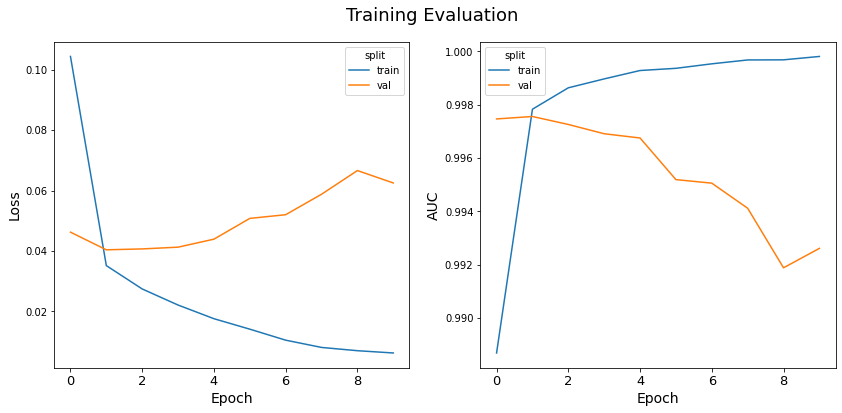

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

sns.lineplot(
  x="epoch",
  y="value", 
  hue="split",
  data=history_tidy[history_tidy.metric == "auc"],
  ax=axes[1]
)

sns.lineplot(
  x="epoch",
  y="value", 
  hue="split",
  data=history_tidy[history_tidy.metric == "loss"],
  ax=axes[0]
)

pretty_plot(axes[0], None, "Epoch", "Loss")
pretty_plot(axes[1], None, "Epoch", "AUC")

fig.suptitle("Training Evaluation", size=18, y=.96);

In [ ]:
model = build_model()
history = model.fit(X_train, y_train.values, batch_size=BATCH_SIZE, epochs=2, validation_split=0.2)

Epoch 1/2
523/523 [==============================] - 104s 187ms/step - loss: 0.2113 - tp: 185287.7118 - fp: 16806.8836 - tn: 46002.2290 - fn: 2324.0725 - accuracy: 0.9175 - precision: 0.9107 - recall: 0.9873 - auc: 0.9577 - val_loss: 0.0419 - val_tp: 49726.0000 - val_fp: 548.0000 - val_tn: 16225.0000 - val_fn: 372.0000 - val_accuracy: 0.9862 - val_precision: 0.9891 - val_recall: 0.9926 - val_auc: 0.9975
Epoch 2/2
523/523 [==============================] - 96s 184ms/step - loss: 0.0320 - tp: 100089.3225 - fp: 866.0973 - tn: 32899.2214 - fn: 543.2557 - accuracy: 0.9898 - precision: 0.9916 - recall: 0.9948 - auc: 0.9981 - val_loss: 0.0379 - val_tp: 49799.0000 - val_fp: 554.0000 - val_tn: 16219.0000 - val_fn: 299.0000 - val_accuracy: 0.9872 - val_precision: 0.9890 - val_recall: 0.9940 - val_auc: 0.9981


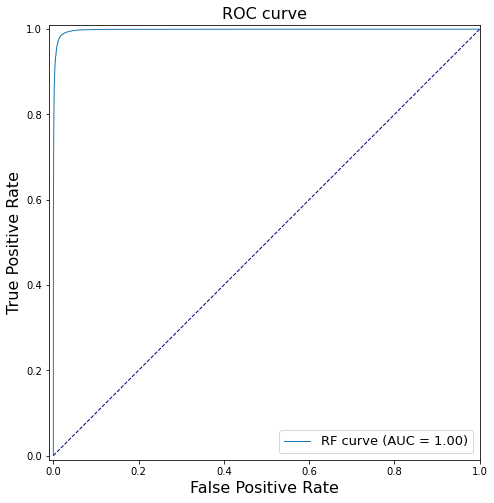

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred = model.predict(X_test)

def plot_prec_rec(y_true, y_pred):
  fpr_rf, tpr_rf, _ = roc_curve(y_true, y_pred)
  roc_auc_rf = auc(fpr_rf, tpr_rf)
  plt.figure(figsize=(8,8))
  plt.xlim([-0.01, 1.00])
  plt.ylim([-0.01, 1.01])
  plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))

  plt.xlabel('False Positive Rate', fontsize=16)
  plt.ylabel('True Positive Rate', fontsize=16)
  plt.title('ROC curve', fontsize=16)
  plt.legend(loc='lower right', fontsize=13)
  plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
  plt.axes().set_aspect('equal')
  plt.show()

plot_prec_rec(y_test, y_pred)

In [ ]:
model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

164/164 [==============================] - 12s 73ms/step - loss: 0.0383 - tp: 62132.0000 - fp: 735.0000 - tn: 20341.0000 - fn: 381.0000 - accuracy: 0.9866 - precision: 0.9883 - recall: 0.9939 - auc: 0.9979


[0.038298871368169785,
 62132.0,
 735.0,
 20341.0,
 381.0,
 0.9866489768028259,
 0.9883086681365967,
 0.993905246257782,
 0.997921884059906]

In [19]:
model, attention_model = build_model(return_attention=True)
history = model.fit(X, y.values, batch_size=512, epochs=2)

Epoch 1/2
817/817 [==============================] - 151s 169ms/step - loss: 0.1816 - tp: 155426.5929 - fp: 7787.5697 - tn: 44716.9389 - fn: 1731.3851 - accuracy: 0.9281 - precision: 0.9261 - recall: 0.9876 - auc: 0.9432
Epoch 2/2
817/817 [==============================] - 139s 170ms/step - loss: 0.0316 - tp: 155980.6919 - fp: 1360.5819 - tn: 51471.1051 - fn: 850.1076 - accuracy: 0.9895 - precision: 0.9915 - recall: 0.9945 - auc: 0.9984


In [20]:
model.save_weights(os.path.join(BASE_DIR, "Attention Layer Lexicon", "attention_base_model.h5"))
attention_model.save_weights(os.path.join(BASE_DIR, "Attention Layer Lexicon", "attention_model.h5"))